In [6]:
import warnings
warnings.filterwarnings('ignore')

import re
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

import datetime as dt
# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

In [7]:
def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

In [8]:
confirmed_df = pd.read_csv("datasets/time_series_covid19_confirmed_global_modified.csv",sep=',')
tests_positive_df = pd.read_csv("datasets/covid-19-tests-vs-cases-positivity-comparisons.csv")
print("Tests positive shaped: ", tests_positive_df.shape)
print("Confirmed shape: ", confirmed_df.shape)

Tests positive shaped:  (14537, 5)
Confirmed shape:  (182, 96)


In [9]:
#Coveeting the string date into datetime pandas object
tests_positive_df['Date'] =  pd.to_datetime(tests_positive_df['Date'])

In [10]:
#Converting the date in dataframe to epoch. It would be easy to compare epoch times to make the data uniform 
#based on the starting and ending date
tests_positive_df['Date'] = (tests_positive_df['Date'] - dt.datetime(1970,1,1)).dt.total_seconds()

In [11]:
#Converting into a timeseries dataframe
jp_tests_positive_df = tests_positive_df.pivot_table(values="Total confirmed cases of COVID-19 (cases)",index="Entity",columns="Date")

In [12]:
#Finding the columns with the same dates in both the dataframes
similar_columns_list_confirmed = []
for col in jp_tests_positive_df.columns:
    if str(col) in confirmed_df.columns:
        similar_columns_list_confirmed.append(col)

In [13]:
# Taking only the columns in with similar columns in both dataframes
jp_tests_positive_df = jp_tests_positive_df[similar_columns_list_confirmed]

similar_columns_list_confirmed = [str(i) for i in similar_columns_list_confirmed]
indexes = ['Country/Region','Country Code','Lat','Long']
lst = list(similar_columns_list_confirmed)
for i in lst:
    indexes.append(i)

final_confirmed_df = confirmed_df[indexes]

In [14]:
# Summing up the total positive cases across all the days
total_tests_positive_df = jp_tests_positive_df.sum(axis=1)
total_tests_positive_df = total_tests_positive_df.to_frame()
total_tests_positive_df.columns = ['Total Positives']

#was facing some problems in directly merging the dataframes as is due to column names not displaying as desired, so writing into a csv
total_tests_positive_df.to_csv("datasets/positives.csv")

#Summing up the total confirmed cases across all days 
final_confirmed_df['Total Confirmed'] = final_confirmed_df[lst].sum(axis=1)
total_confirmed_df = final_confirmed_df[['Country/Region','Country Code','Lat','Long','Total Confirmed']]

total_confirmed_df.head()

,Country/Region,Country Code,Lat,Long,Total Confirmed
0,Afghanistan,AFG,33.00,65.00,15197
1,Albania,ALB,41.15,20.17,12060
2,Algeria,DZA,28.03,1.66,46533
3,Andorra,AND,42.51,1.52,15989
4,Angola,AGO,-11.20,17.87,440


In [15]:
# Reading the earlier total positives dataset and renaming the columns according to merge into a single dataset having the total confirmed cases and total positives
#based on countries
final_positives_df = pd.read_csv('datasets/positives.csv')
final_positives_df.columns = ['Country/Region','Total Positives']

final_positives_df.head()

,Country/Region,Total Positives
0,Afghanistan,13417.0
1,Africa,342286.0
2,Albania,11433.0
3,Algeria,43575.0
4,Andorra,15314.0


In [16]:
#Final data set having aggregated confirmed and positive cases
final_df = pd.merge(total_confirmed_df,final_positives_df,on='Country/Region')
final_df.to_csv("datasets/aggregated_counts.csv")

final_df.head()

,Country/Region,Country Code,Lat,Long,Total Confirmed,Total Positives
0,Afghanistan,AFG,33.00,65.00,15197,13417.0
1,Albania,ALB,41.15,20.17,12060,11433.0
2,Algeria,DZA,28.03,1.66,46533,43575.0
3,Andorra,AND,42.51,1.52,15989,15314.0
4,Angola,AGO,-11.20,17.87,440,409.0


In [17]:
#Reading the data having the GDP per capita and population density
popdensity_gdp_df = pd.read_csv('datasets/gdp_per_capita_and_population_density.csv',usecols=['Country Name','GDP per capita (current US$)','Population density'])

In [18]:
popdensity_gdp_df.columns = ['Country/Region','GDP per capita','Population density']

In [19]:
#Combining the Total Confirmed and GDP per capita of different countries
confirmed_vs_gdp = pd.merge(final_df[['Country/Region','Country Code','Total Confirmed']],popdensity_gdp_df[['Country/Region','GDP per capita']],on='Country/Region')
confirmed_vs_gdp.head()

,Country/Region,Country Code,Total Confirmed,GDP per capita
0,Afghanistan,AFG,15197,637
1,Albania,ALB,12060,4413
2,Algeria,DZA,46533,5499
3,Andorra,AND,15989,40626
4,Angola,AGO,440,5254


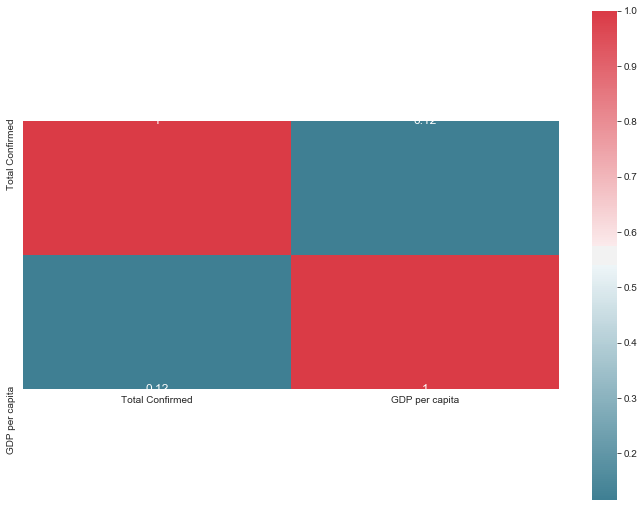

In [20]:
# import seaborn as sns
# gdp_correlation = confirmed_vs_gdp.corr()
# sns.heatmap(gdp_correlation, xticklabels=gdp_correlation.columns, yticklabels=gdp_correlation.columns)
plot_correlation_map(confirmed_vs_gdp)

In [21]:
gdp_correlation = confirmed_vs_gdp.corr()
print(gdp_correlation)

                 Total Confirmed  GDP per capita
Total Confirmed         1.000000        0.115883
GDP per capita          0.115883        1.000000


In [22]:
#Combining the Total Confirmed and population density of different countries
confirmed_vs_pop_density = pd.merge(final_df[['Country/Region','Country Code','Total Confirmed']],popdensity_gdp_df[['Country/Region','Population density']],on='Country/Region')
confirmed_vs_pop_density.head()

,Country/Region,Country Code,Total Confirmed,Population density
0,Afghanistan,AFG,15197,49
1,Albania,ALB,12060,105
2,Algeria,DZA,46533,16
3,Andorra,AND,15989,171
4,Angola,AGO,440,20


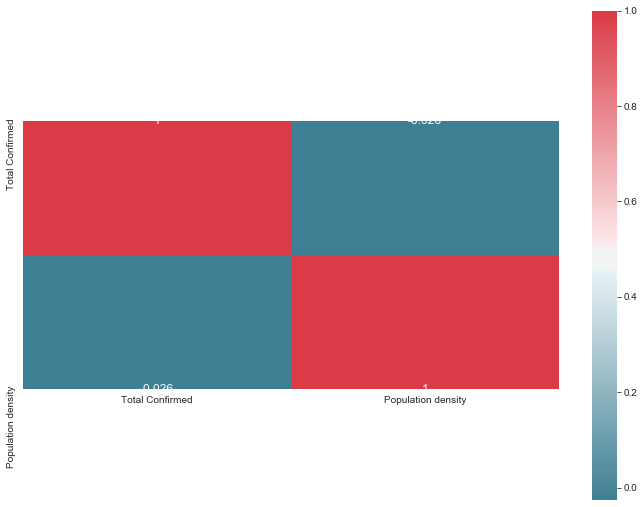

In [23]:
# popdensity_correlation = confirmed_vs_pop_density.corr()
# sns.heatmap(popdensity_correlation, xticklabels=popdensity_correlation.columns, yticklabels=popdensity_correlation.columns)

plot_correlation_map(confirmed_vs_pop_density)

In [24]:
popdensity_correlation = confirmed_vs_pop_density.corr()
print(popdensity_correlation)

                    Total Confirmed  Population density
Total Confirmed            1.000000           -0.025748
Population density        -0.025748            1.000000


In [25]:
#Finding the correlation between all the columns
info_dataframe_1 = pd.merge(final_df[['Country/Region','Total Confirmed','Total Positives']],popdensity_gdp_df,on='Country/Region')

In [26]:
print(info_dataframe_1.corr())

                    Total Confirmed  Total Positives  GDP per capita  \
Total Confirmed            1.000000         0.998481        0.115883   
Total Positives            0.998481         1.000000        0.107656   
GDP per capita             0.115883         0.107656        1.000000   
Population density        -0.025748        -0.025254        0.484073   

                    Population density  
Total Confirmed              -0.025748  
Total Positives              -0.025254  
GDP per capita                0.484073  
Population density            1.000000  


In [27]:
#Reading the data having the GDP per capita and population density and population from a different source
# I find that these numbers are better to use as we have the population, population density as well as the
#Urban population numbers
country_info_df = pd.read_csv('datasets/Populations_and_popdensity.csv')
country_info_df.head()

,Country/Region,Population,Density,Urban Population
0,Afghanistan,38928346,60,9732086.50
1,Albania,2877797,105,1813012.11
2,Algeria,43851044,18,32011262.12
3,American Samoa,55191,276,48568.08
4,Andorra,77265,164,67993.20


In [28]:
# I think this is the best merged dataset that i was able to prepare using the dataI could get hands on
info_dataframe_2= pd.merge(final_df[['Country/Region','Total Confirmed','Total Positives']],country_info_df,on='Country/Region')

In [29]:
info_dataframe_2.head()

,Country/Region,Total Confirmed,Total Positives,Population,Density,Urban Population
0,Afghanistan,15197,13417.0,38928346,60,9732086.50
1,Albania,12060,11433.0,2877797,105,1813012.11
2,Algeria,46533,43575.0,43851044,18,32011262.12
3,Andorra,15989,15314.0,77265,164,67993.20
4,Angola,440,409.0,32866272,26,22020402.24


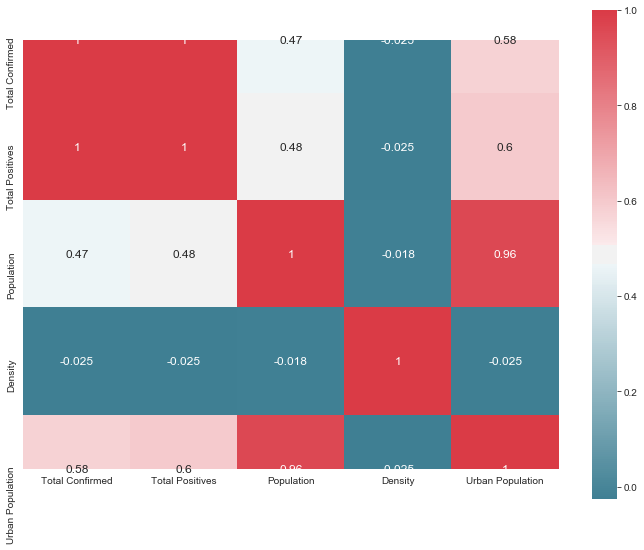

In [30]:
# The heatmap clearly shows that there is a good positive correlation between the POPULATION, URBAN POPULATION
#when correlated with TOTAL POSITIVE cases and TOTAL CONFIRMED CASES 
plot_correlation_map(info_dataframe_2)

In [31]:
print(info_dataframe_2.corr())

                  Total Confirmed  Total Positives  Population   Density  \
Total Confirmed          1.000000         0.998484    0.465506 -0.025490   
Total Positives          0.998484         1.000000    0.482459 -0.024978   
Population               0.465506         0.482459    1.000000 -0.018319   
Density                 -0.025490        -0.024978   -0.018319  1.000000   
Urban Population         0.577561         0.596982    0.958833 -0.024700   

                  Urban Population  
Total Confirmed           0.577561  
Total Positives           0.596982  
Population                0.958833  
Density                  -0.024700  
Urban Population          1.000000  


In [39]:
# I think this is the best merged dataset that i was able to prepare using the dataI could get hands on
info_dataframe_2= pd.merge(final_df[['Country/Region','Lat','Long','Total Confirmed','Total Positives']],country_info_df,on='Country/Region')

In [55]:
from sklearn.cluster import MeanShift,estimate_bandwidth
temp_df = info_dataframe_2
temp_df['Country/Region'] = info_dataframe_2['Country/Region'].apply(lambda x: int(countries.get(x).numeric))
clustering_df = temp_df.to_numpy()
bandwidth = estimate_bandwidth(clustering_df, quantile=0.2, n_samples=500)
mean_shift_clusters = MeanShift(bandwidth=bandwidth,n_jobs=5,max_iter=350).fit(clustering_df)

In [56]:
labels = mean_shift_clusters.labels_
cluster_centers = mean_shift_clusters.cluster_centers_
labels_unique = np.unique(labels)
clusters = len(labels_unique)

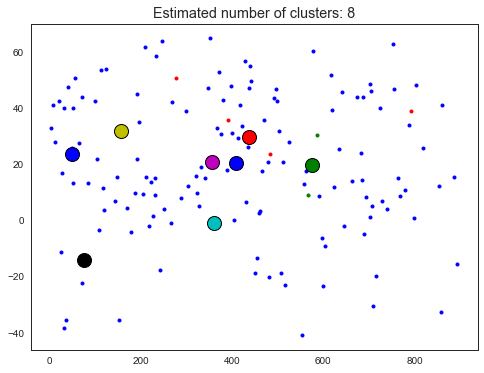

In [57]:
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(clusters), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(clustering_df[my_members, 0], clustering_df[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % clusters)
plt.show()